Imports, opening datafiles and reading them using wfdb.rdrecord and rdann. Plot them using wfdb.plot_wfdb and append the first channel data to pchannel.

In [175]:
import os
import glob
import re
import wfdb as wf
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter

samplenumber=3000    #sample size for analysis

filenames = glob.glob('DataFiles/*.dat') #reading files from DataFiles folder
pchannel=[] #initiating arrays
file_nums=[]
pfreq=[]
recordall=[]
annall=[]

for i, s in enumerate(filenames):                 
    num_str = re.search("(\d+).dat",  filenames[i]) 
    file_nums.append(num_str.group(1)) #extracting the numbering system of the data files, saving them to an array for calling them in the future 
    
for j, k in enumerate(file_nums):
    record = wf.rdrecord('Datafiles/'+file_nums[j], sampto=samplenumber)
    pchannel.append(record.p_signal[:,0])
    ann = wf.rdann('DataFiles/'+file_nums[j], 'atr', sampto=samplenumber) #reading the data and annotation files, putting them into arrays up to the 3000th sample -arbitrary
    #wf.plot_wfdb(record=record, annotation = ann, title='Record '+file_nums[j]+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,10)) #plotting all of the files

First step in detecting QRS complex peaks using the Pan-Tomkins algorithm. It involves a 1)bandpass filter, a 2)differentiation, a 3)squaring function, and finally a 4)moving window integration.

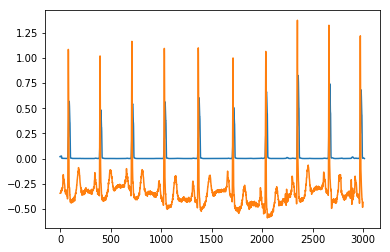

In [200]:
datanumb=1    #which data set to look at
lowcut=5      #low frequency cutoff for bandpass filter
highcut=50    #high frequency cutoff for bandpass filter
window=15     #window size for moving window integration

ffin=[]

nyquist_freq = 0.5 * record.fs #calculating the nyquist frequency using the sampling frequency
low = lowcut / nyquist_freq #lowpass filtering cutoff
high = highcut / nyquist_freq #highpass filtering cutoff
b, a = butter(1, [low, high], btype="band")
x = lfilter(b, a, pchannel[datanumb]) #bandpass filtering
y = np.ediff1d(x) #deriving the data
z = [i**2 for i in y] #squaring the data
fin = np.convolve(z, np.ones(window)) #convolving the data- moving window integration
#ffin.append(fin)

#plt.plot(x)
#plt.plot(pchannel[0])
#plt.plot(y)
#plt.plot(z)
plt.plot(fin)
plt.plot(pchannel[datanumb])

Detecting peaks part 2

In [199]:
spacing = 50    #min spacing between peaks
limit = 0.1     #amplitude detection limit

siz = fin.size
x = np.zeros(siz + 2 * spacing)
x[:spacing] = fin[0] - 1.e-6
x[-spacing:] = fin[-1] - 1.e-6
x[spacing:spacing + siz] = fin
peak_candidate = np.zeros(siz)
peak_candidate[:] = True
for s in range(spacing):
    start = spacing - s - 1
    h_b = x[start: start + siz]  # before
    start = spacing
    h_c = x[start: start + siz]  # central
    start = spacing + s + 1
    h_a = x[start: start + siz ]  # after
    peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))
ind = np.argwhere(peak_candidate)
ind = ind.reshape(ind.size)
ind = ind[fin[ind] > limit]


Extracting features based on peak location. Relevant features: 

array([0.01882309, 0.01882309, 0.01882309, ..., 0.00046633, 0.00046633,
       0.00046633])